## Linear Elastic Fracture Mechanics

In this notebook, we analyze the stress and displacement fields around a crack tip using Finite Element Method. We will use the LEFM (Linear Elastic Fracture Mechanics) theory to compare the results with the analytical solutions. To this end, we model a through crack in an infinite plate. 

In [1]:
#| code-fold: true
#| code-summary: "Code: Import essential libraries"
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import gmsh
import numpy as np
import meshio

import equinox as eqx
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

## Model setup

We define a plate of dimension $L_x \times L_y$ with a crack of length $l_c$ from the left edge. The plate is made of a linear elastic material with a linear relationship between stress and strain. We will apply symmetric boundary condition on the left edge of the plate to ensure that the crack is symmetric. The infiniteness of the plate is modelled by assuming a very large values of $L_x$ and $L_y$ compared to the crack length.

We generate mesh for the given plate such that the mesh near the crack tip is refined. This is required to capture the stress field near the crack tip accurately.

In [6]:
#| code-fold: true
#| output: false
#| code-summary: "Function to generate a mesh with a pre-crack"

def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)
    
    return jnp.array(elements_1d)

def generate_cracked_plate_mesh(
    length: float,
    height: float,
    crack_tip_coords: tuple[float, float],
    mesh_size_crack: float,
    mesh_size_far: float,
    refine_dist_crack: float,
    output_filename: str = "model.msh"
):
    """
    Generates a 2D mesh using the Gmsh Python API based on the provided .geo script.

    Args:
        length (float): Total length 'L' of the domain.
        height (float): Total height 'H' of the domain.
        lc (float): Characteristic length 'l' for the initial point.
        min_elem (float): Minimum element size for the refinement box.
        output_filename (str): Name of the output mesh file (e.g., 'model.msh').
    """
    gmsh.initialize()
    gmsh.model.add("refined_plate")

    # --- Use OpenCASCADE geometry kernel ---
    #gmsh.model.setFactory("OpenCASCADE")
    
    # --- Define script parameters ---
    h2 = 1.0
    epsilon = 1e-5
    depth = 0.0

    # --- Define geometry points ---
    # The last argument is the prescribed mesh size at that point.
    p1 = gmsh.model.geo.addPoint(0, epsilon, -depth / 2)
    p2 = gmsh.model.geo.addPoint(crack_tip_coords[0], crack_tip_coords[1], -depth / 2)
    p3 = gmsh.model.geo.addPoint(0, -epsilon, -depth / 2)
    p4 = gmsh.model.geo.addPoint(0, -height / 2, -depth / 2)
    p5 = gmsh.model.geo.addPoint(length, -height / 2, -depth / 2)
    p6 = gmsh.model.geo.addPoint(length, height / 2, -depth / 2)
    p7 = gmsh.model.geo.addPoint(0, height / 2, -depth / 2)

    # --- Define lines connecting the points ---
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p5)
    l5 = gmsh.model.geo.addLine(p5, p6)
    l6 = gmsh.model.geo.addLine(p6, p7)
    l7 = gmsh.model.geo.addLine(p7, p1)

    # --- Define curve loops and surfaces ---
    # A negative tag in a loop reverses the line's direction.
    loop1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6, l7])
    
    surface1 = gmsh.model.geo.addPlaneSurface([loop1])

    #crack_tip_p = gmsh.model.geo.addPoint(crack_tip_coords[0], crack_tip_coords[1], 0)


    # Synchronize the CAD kernel with the Gmsh model
    gmsh.model.geo.synchronize()

    # --- Define Physical Groups ---
    # Physical groups are used to identify boundaries and domains.
    # Physical Line(2) = {{2}};
    gmsh.model.addPhysicalGroup(1, [loop1], 2) # dim=1 for lines
    # Physical Surface(1) = {{1, 2}};
    gmsh.model.addPhysicalGroup(2, [surface1], 1) # dim=2 for surfaces

    # --- Define Mesh Refinement Field ---
    dist_field_crack = gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(dist_field_crack, "PointsList", [p2])
    
    thresh_field_crack = gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "InField", dist_field_crack)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "SizeMin", mesh_size_crack)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "SizeMax", mesh_size_far)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "DistMin", refine_dist_crack)
    gmsh.model.mesh.field.setNumber(
        thresh_field_crack, "DistMax", refine_dist_crack * 2
    )

    
    # Set this field as the background field, which Gmsh uses to drive mesh generation.
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field_crack)

    # --- Set global mesh options ---
    # These options prevent Gmsh from overriding the background field.
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromPoints", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromCurvature", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthExtendFromBoundary", 0)
    
    # --- Generate the 2D mesh ---
    gmsh.model.mesh.generate(2)

    # --- Save the mesh and optionally launch the GUI ---
    gmsh.write(output_filename)
    print(f"Mesh saved to '{output_filename}'")
    gmsh.finalize()


    _mesh = meshio.read(output_filename)

    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh



In [24]:
#| output: false

crack_length = 0.08
length = 0.4
height = 0.4

refine_dist_crack = 0.02

params = {
    "length": length,
    "height": height,
    "crack_tip_coords": (crack_length, 0.0),
    "mesh_size_crack": 2.5e-4,
    "mesh_size_far": 5e-3,
    "refine_dist_crack": refine_dist_crack,
    "output_filename": "refined_model.msh",
}

mesh = generate_cracked_plate_mesh(**params)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00375073s, CPU 0.004252s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.08302s, CPU 1.06193s)
Info    : 33935 nodes 67875 elements
Info    : Writing 'refined_model.msh'...
Mesh saved to 'refined_model.msh'
Info    : Done writing 'refined_model.msh'



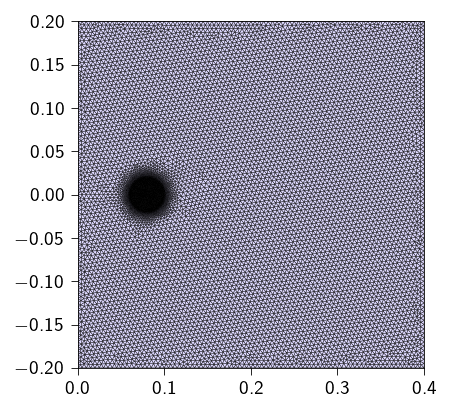

In [25]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Visualization of the mesh."
# | code-summary: "Plot the mesh."

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.2,
    cmap=cmc.tofino,
)

ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

## Defining total energy 

We assume a linear elastic material with a linear relationship between stress and strain.

In [26]:
E = 1.0
nu = 0.3

mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))


In [27]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=mu, lmbda=lmbda)

In [28]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))

@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)


@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)


Now, we derive the functions to compute the internal forces and the stiffness matrix using automatic differentiation.

In [29]:
from femsolver import sparse

In [30]:
sparsity_pattern = sparse.create_sparsity_pattern(mesh, n_dofs_per_node=n_dofs_per_node)

In [31]:

gradient = jax.jacrev(total_energy)
hessian_sparse = sparse.jacfwd(
    jax.jacrev(total_energy), sparsity_pattern=sparsity_pattern
)

## Applying Dirichlet boundary conditions

We apply a prestrain of $\varepsilon_{\infty} = 0.01$ to the top and bottom edges of the plate. The prestrain is applied in the direction of the $y$-axis. The prestrain is applied as displacement boundary conditions both on the top and the botttom nodes. 
$$
u_y (y=y_\text{max}) = \varepsilon_{\infty} L_y / 2.
$$
$$
u_y (y=y_\text{min}) = -\varepsilon_{\infty} L_y / 2
$$

where $L_y$ is the height of the plate.


In [32]:
prestrain = 0.01

y_max = np.max(mesh.coords[:, 1])
y_min = np.min(mesh.coords[:, 1])
x_min = np.min(mesh.coords[:, 0])
x_max = np.max(mesh.coords[:, 0])

height = y_max - y_min
applied_displacement = prestrain * height

In [33]:
top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
bottom_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_max))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * top_nodes,
        2 * top_nodes + 1,
        2 * bottom_nodes,
        2 * bottom_nodes + 1,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

prescribed_values = jnp.zeros(n_dofs)
prescribed_values = prescribed_values.at[2 * top_nodes + 1].set(
    applied_displacement / 2.0
)
prescribed_values = prescribed_values.at[2 * bottom_nodes + 1].set(
    -applied_displacement / 2.0
)

zero_indices, one_indices = sparse.get_bc_indices(sparsity_pattern, fixed_dofs)

## Solve the system

We use `Newton-Raphson` method to solve the system of equations where the linear system of equation within each iteration is solved using direct sparse solver.

We divide the total displacement into 10 steps and solve the system of equations for each step.

In [34]:
#| code-fold: true
#| code-summary: "Newton-Raphson solver"

import scipy.sparse as sp

def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)
    K_sparse = hessian_sparse(u)
    indices = K_sparse.indices

    du = jnp.zeros_like(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 110

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix((K_data_lifted, (indices[:, 0], indices[:, 1])))

        du = sp.linalg.spsolve(K_csr, residual)

        u = u.at[:].add(du)
        fint = gradient(u)
        K_sparse = hessian_sparse(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        print(f"  Residual: {norm_res:.2e}")
        iiter += 1

    return u, norm_res

In [35]:
#| output: false

u = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 10

du_total = prescribed_values / n_steps  # displacement increment
for step in range(n_steps):
    print(f"Step {step+1}/{n_steps}")
    u = u.at[fixed_dofs].add(du_total[fixed_dofs])

    u_new, rnorm = newton_scipy_solver(
        u,
        fext,
        gradient,
        hessian_sparse,
        fixed_dofs,
        zero_indices,
        one_indices,
    )

    u = u_new

u_solution = u.reshape(n_nodes, n_dofs_per_node)

Step 1/10
  Residual: 1.38e-17
Step 2/10
  Residual: 1.53e-17
Step 3/10
  Residual: 1.69e-17
Step 4/10
  Residual: 1.84e-17
Step 5/10
  Residual: 1.98e-17
Step 6/10
  Residual: 2.32e-17
Step 7/10
  Residual: 2.57e-17
Step 8/10
  Residual: 2.76e-17
Step 9/10
  Residual: 2.91e-17
Step 10/10
  Residual: 3.14e-17


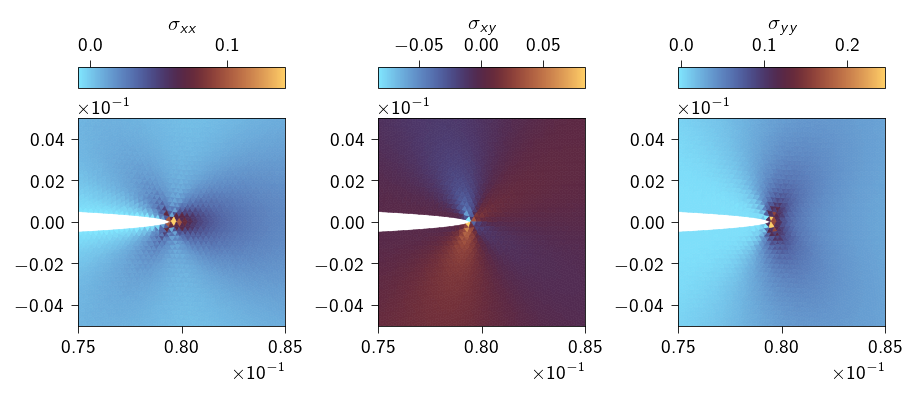

In [37]:
#| code-fold: true
#| code-summary: "Plot the stress field in front of the crack tip"
#| fig-align: center
#| fig-cap: "Full visualization of stress fields around the crack tip."


from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tools import plot_element_values


grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)



fig = plt.figure(layout="constrained", figsize=(6, 5))

gs = GridSpec(1, 3, figure=fig, width_ratios=[0.32, 0.32, 0.32], wspace=0.0)
ax = fig.add_subplot(gs[0, 0])
plot_element_values(u_solution, mesh, stresses[:, 0, 0], ax=ax, label=r"$\sigma_{xx}$")
ax.ticklabel_format(axis='both', style='sci', scilimits=(-1, -1))
ax.set_xlim(crack_length-refine_dist_crack/4, crack_length + refine_dist_crack/4)
ax.set_ylim(-refine_dist_crack/4, refine_dist_crack/4)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)

ax = fig.add_subplot(gs[0, 1])
plot_element_values(u_solution, mesh, stresses[:, 0, 1], ax=ax, label=r"$\sigma_{xy}$")
ax.ticklabel_format(axis='both', style='sci', scilimits=(-1, -1))
ax.set_xlim(crack_length-refine_dist_crack/4, crack_length + refine_dist_crack/4)
ax.set_ylim(-refine_dist_crack/4, refine_dist_crack/4)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)

ax = fig.add_subplot(gs[0, 2])
plot_element_values(u_solution, mesh, stresses[:, 1, 1], ax=ax, label=r"$\sigma_{yy}$")
ax.ticklabel_format(axis='both', style='sci', scilimits=(-1, -1))
ax.set_xlim(crack_length-refine_dist_crack/4, crack_length + refine_dist_crack/4)
ax.set_ylim(-refine_dist_crack/4, refine_dist_crack/4)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)


plt.show()

## Comparing numerical results with LEFM theory

We now plot the stress field along the line $x=0$. We will use the analytical solution from LEFM to compare with the FEM solution.

The analytical solution for the stress field is given by:

$$
\sigma_{xx} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) [1- \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})]
$$

$$
\sigma_{xy} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})
$$

$$
\sigma_{yy} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) [1 + \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})]
$$

where $K_I$ is the stress intensity factor, $r$ is the distance from the crack tip, and $\theta$ is the angle from the crack tip.

The stress intensity factor $K_I$ for crack in an infinite plate is given by:

$$
K_I = \kappa\sigma_{\infty} \sqrt{\pi a}
$$

where $\sigma_{\infty}$ is the remote stress, $a$ is the crack length and $\kappa$ is a factor that depends on the geometry. For an infinite plate, $\kappa=1.0$.


Under plane strain conditions and for a given prestrain $\varepsilon_{\infty}$, the remote stress is given by:

$$
\sigma_{\infty} = \frac{E}{1-\nu^2} \varepsilon_{\infty}
$$


In [38]:
def analytical_stress_field(r, sigma_inf, lc, theta=0, kappa=1.0):
    K_I = kappa * sigma_inf * jnp.sqrt(jnp.pi * lc)
    sigma_xx = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * (1 - jnp.sin(theta / 2) * jnp.sin(3 * theta / 2))
    )
    sigma_xy = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * jnp.sin(theta / 2)
        * jnp.sin(3 * theta / 2)
    )
    sigma_yy = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * (1 + jnp.sin(theta / 2) * jnp.sin(3 * theta / 2))
    )
    return jnp.array([sigma_xx, sigma_xy, sigma_yy]).T

Now, lets calculate the stress field along the line $y=0$ from the FEM solution. To this end, we give a list of points along the line $y=0$ where we would like to calculate the stress field. We find the finite element which contains each of these points and then take the stress values corresponding to each of these elements. 

::: {.callout-tip}
Since we use triangular elements with one integration point, therefore we can directly use the associated stress values at the integration point as the stress values at the point of interest. However, in general, we should interpolate the stress values to the point of interest.
:::

In [39]:
#| code-fold: true
#| code-summary: "Function to find the index of the containing polygon for each point."

import numpy as np

@jax.jit
def find_containing_polygons(
    points: jnp.ndarray,
    polygons: jnp.ndarray,
) -> jnp.ndarray:
    """
    Finds the index of the containing polygon for each point.

    This function uses a vectorized Ray Casting algorithm and is JIT-compiled
    for maximum performance. It assumes polygons are non-overlapping.

    Args:
        points (jnp.ndarray): An array of points to test, shape (num_points, 2).
        polygons (jnp.ndarray): A 3D array of polygons, where each polygon is a
                                list of vertices. Shape (num_polygons, num_vertices, 2).

    Returns:
        jnp.ndarray: An array of shape (num_points,) where each element is the
                     index of the polygon containing the corresponding point.
                     Returns -1 if a point is not in any polygon.
    """

    # --- Core function for a single point and a single polygon ---
    def is_inside(point, vertices):
        px, py = point
        
        # Get all edges of the polygon by pairing vertices with the next one
        p1s = vertices
        p2s = jnp.roll(vertices, -1, axis=0) # Get p_{i+1} for each p_i

        # Conditions for a valid intersection of the horizontal ray from the point
        # 1. The point's y-coord must be between the edge's y-endpoints
        y_cond = (p1s[:, 1] <= py) & (p2s[:, 1] > py) | \
                 (p2s[:, 1] <= py) & (p1s[:, 1] > py)
        
        # 2. The point's x-coord must be to the left of the edge's x-intersection
        # Calculate the x-intersection of the ray with the edge
        x_intersect = (p2s[:, 0] - p1s[:, 0]) * (py - p1s[:, 1]) / \
                      (p2s[:, 1] - p1s[:, 1]) + p1s[:, 0]
        x_cond = px < x_intersect
        
        # An intersection occurs if both conditions are met.
        intersections = jnp.sum(y_cond & x_cond)
        
        # The point is inside if the number of intersections is odd.
        return intersections % 2 == 1

    # --- Vectorize and apply the function ---
    # Create a boolean matrix: matrix[i, j] is True if point i is in polygon j
    # Vmap over points (axis 0) and polygons (axis 0)
    # in_axes=(0, None) -> maps over points, polygon is fixed
    # in_axes=(None, 0) -> maps over polygons, point is fixed
    # We vmap the second case over all points
    is_inside_matrix = jax.vmap(lambda p: jax.vmap(lambda poly: is_inside(p, poly))(polygons))(points)

    # Find the index of the first 'True' value for each point (row).
    # This gives the index of the containing polygon.
    # We add a 'False' column to handle points outside all polygons.
    # jnp.argmax will then return the index of this last column.
    padded_matrix = jnp.pad(is_inside_matrix, ((0, 0), (0, 1)), 'constant', constant_values=False)
    indices = jnp.argmax(padded_matrix, axis=1)
    
    # If the index is the last one, it means the point was not in any polygon.
    # We map this index to -1 for clarity.
    return jnp.where(indices == is_inside_matrix.shape[1], -1, indices)

In [40]:
x = np.linspace(crack_length, crack_length + refine_dist_crack, 200)
y = np.full_like(x, fill_value=1e-12)

points = np.stack([x, y], axis=1)
containing_indices = find_containing_polygons(points, mesh.coords[mesh.elements])

stress_field = stresses[containing_indices, :, :]


r = jnp.linalg.norm(points - jnp.array([crack_length, 1e-6]), axis=1)

E_eff = E / (1-nu**2)

sigma_inf = prestrain * E_eff
ana_stress_field = analytical_stress_field(r, sigma_inf, crack_length, kappa=1.0)

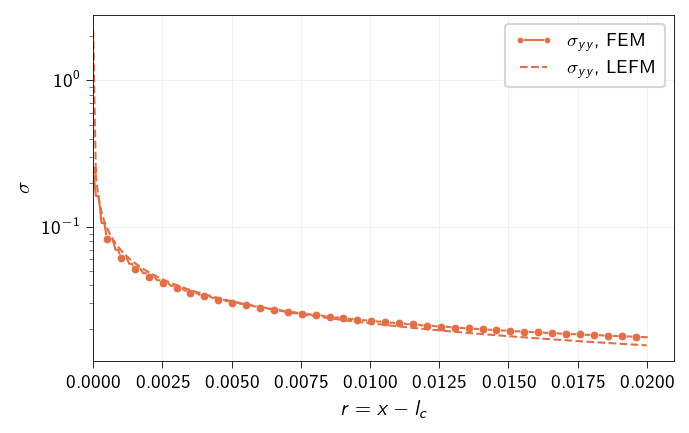

In [42]:
#| code-fold: true
#| code-summary: "Plot the stress field in front of the crack tip"
#| fig-align: center
#| fig-cap: "Stress field in front of the crack tip ($y=0$). Comparison with LEFM."

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.semilogy(r, stress_field[:, 1, 1], 'o-', label=r'$\sigma_{yy},$ FEM', color=colors.red, markevery=5)
ax.semilogy(r, ana_stress_field[:, 2], ls='--', label=r'$\sigma_{yy},$ LEFM', color=colors.red)

ax.set_xlabel(r'$r = x - l_c$')
ax.set_ylabel(r'$\sigma$')
ax.grid(True)
ax.set_xlim(left=0)
ax.legend()
plt.show()